# Resonant innelastic X-ray scattering (RIXS) 

In this notebook we will analyze a RIXS experiment measurement for Ni MOF. RIXS, also known as resonant X-ray emission spectrscopy (RXES), is a photon-in/photon-out experiment. The incident energy Ω is scanned across an absorption edge. The emitted energy ω is also scanned either over the fluorescence lines or over energies just below the elastically scattered peak. In the latter case, the energy transfer Ω-ω becomes small (on the order of a few eV) and valence band excitations are observed.

<figure>
  <img src="assets/rixs.png" alt="XAS" style="width:40%">
  <figcaption style="text-align: center; font-style: italic">P. Glatzel et al., The European Physical Journal Special Topics 169, 207 (2009).
</figcaption>
</figure>

The RIXS plane (bottom left) based on the above energy diagram and corresponding line plots. The lifetime broadenings for the intermediate state and final state are shown as straight lines in the plane. Line plots are shown at constant incident energy (bottom right) and constant final state energy or constant energy transfer (top left). A diagonal line through the RIXS plane (dashed) corresponds to a scan of the incident energy at fixed emission energy (HERFD). 

<figure>
  <img src="assets/rixs_plane.png" alt="XAS" style="width:60%">
  <figcaption style="text-align: center; font-style: italic">P. Glatzel et al., The European Physical Journal Special Topics 169, 207 (2009).
</figcaption>
</figure>

# Import the required packages and set up logging

In [1]:
%matplotlib notebook

import sys
import logging

import numpy as np
import scipy
import matplotlib.pyplot as plt

from daxs.measurements import Source, Rixs

logging.basicConfig(level=logging.INFO, stream=sys.stdout)
logging.getLogger("daxs").setLevel(logging.DEBUG)

## Load the experimental data

In [2]:
filename = "experimental_data/ihch1527/id26/Sami_Ni_MOF_RIXS_cc/Sami_Ni_MOF_RIXS_cc_Ka1/Sami_Ni_MOF_RIXS_cc_Ka1.h5"
scans_id = "3-83"
source = Source(filename=filename, inclusions=scans_id)

counters = {"x": "hdh_energy", "signal": "det_dtc_apd", "monitor": "I02"}
measurement = Rixs(source, counters)

## A note on plotting 2D data

In [3]:
x, y, signal = measurement.x, measurement.y, measurement.signal

<IPython.core.display.Javascript object>


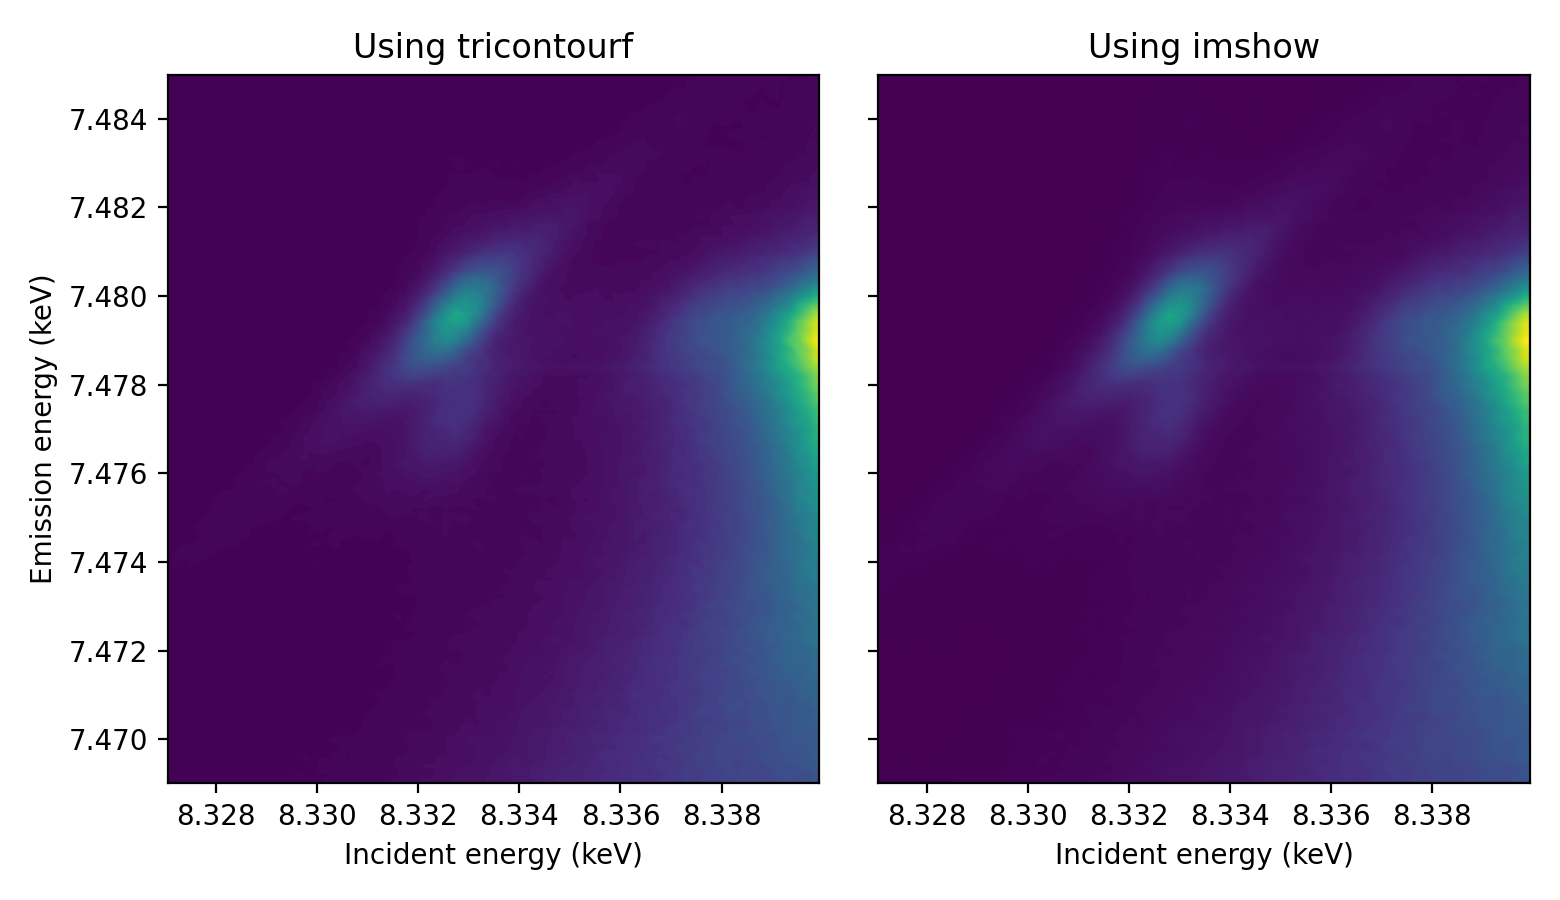

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.8, 4.5), sharey=True)

# Plot using tricontourf.
levels = 101
ax1.tricontourf(x, x - y, signal, levels=levels)
ax1.set_xlabel("Incident energy (keV)")
ax1.set_ylabel("Emission energy (keV)")
ax1.set_title("Using tricontourf")

# Plot using imshow. The data needs to be reshaped.
nscans = 81
npoints_per_scan = 66
signal_reshaped = signal.reshape((nscans, npoints_per_scan))

# https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html
interpolation = "bilinear"
extent = [x.min(), x.max(), (x - y).min(), (x - y).max()]
ax2.imshow(
    signal_reshaped,
    origin="lower",
    extent=extent,
    aspect="auto",
    interpolation=interpolation,
)
ax2.set_xlabel("Incident energy (keV)")
ax2.set_title("Using imshow")

plt.tight_layout()


## Emission energy vs energy transfer plots

<IPython.core.display.Javascript object>


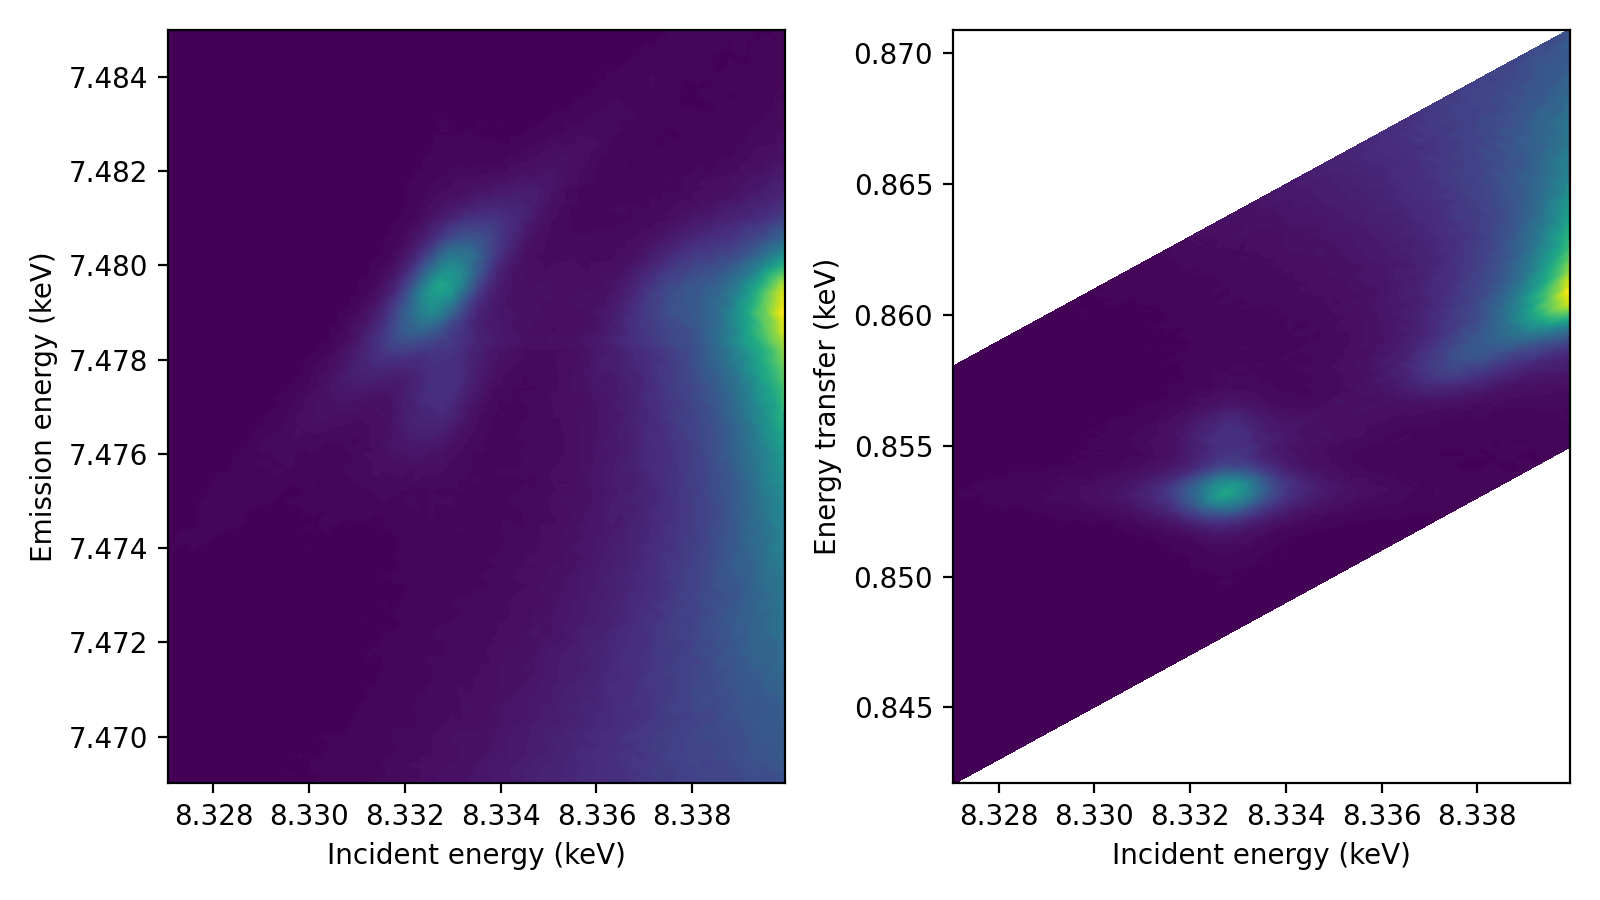

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

# Plot the plane with the emission energy as Y-axis.
ax1.tricontourf(x, x - y, signal, levels=levels)
ax1.set_xlabel("Incident energy (keV)")
ax1.set_ylabel("Emission energy (keV)")

# Plot the plane with the energy transfer as Y-axis.
ax2.tricontourf(x, y, signal, levels=levels)
ax2.set_xlabel("Incident energy (keV)")
ax2.set_ylabel("Energy transfer (keV)")

plt.tight_layout()

## Apply the concentration correction

<IPython.core.display.Javascript object>


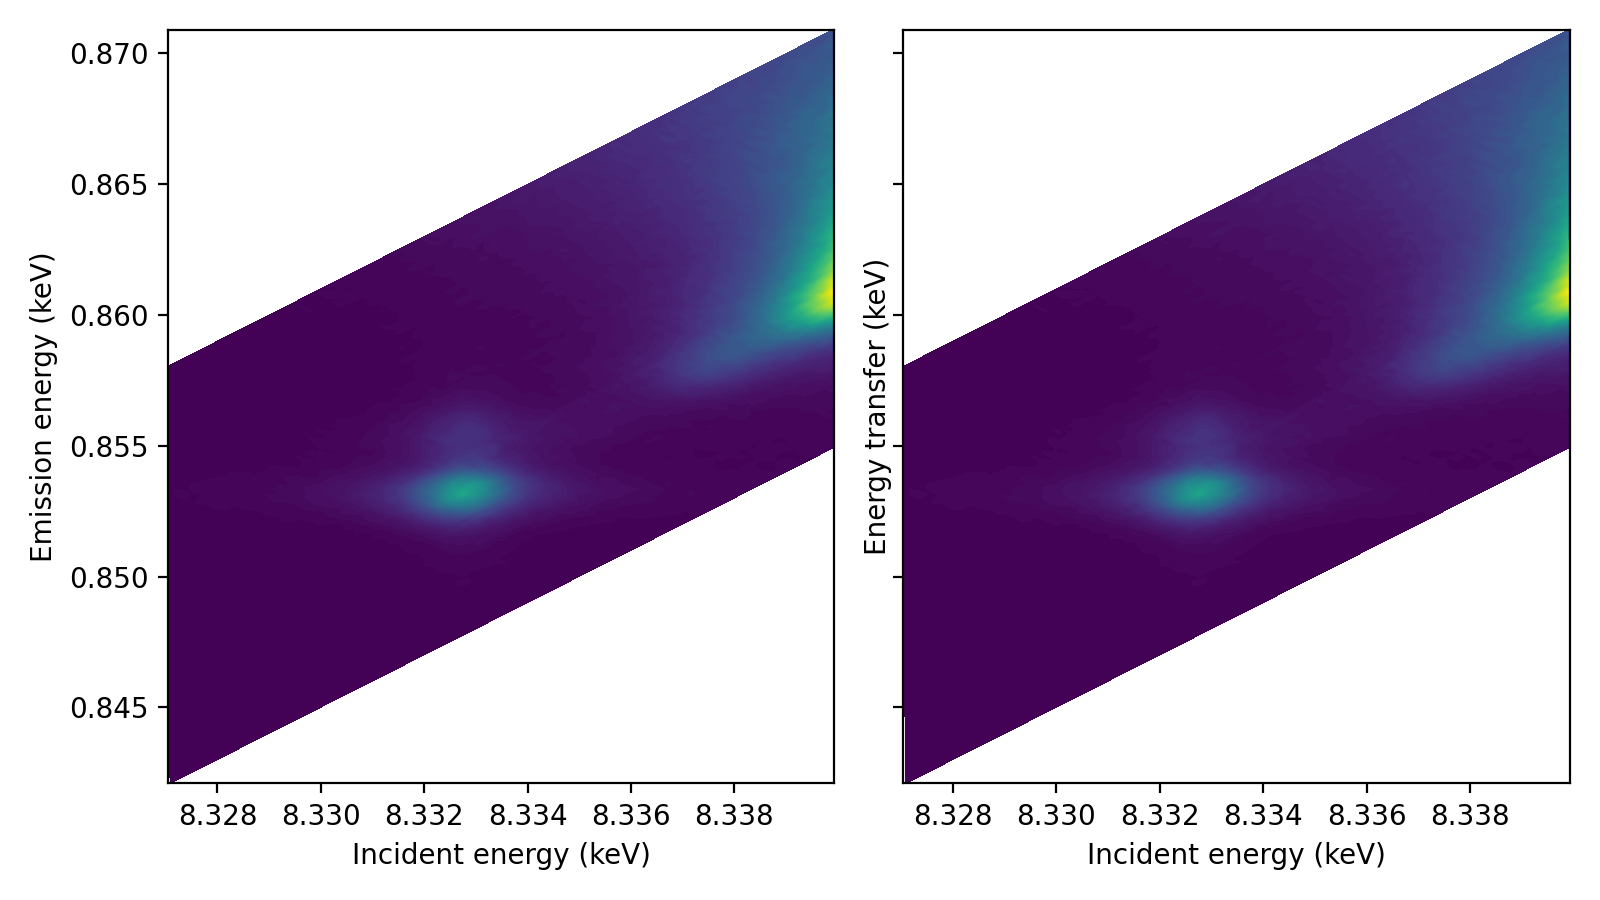

INFO:daxs.measurements:Reading correction scan 84.1 from experimental_data/ihch1527/id26/Sami_Ni_MOF_RIXS_cc/Sami_Ni_MOF_RIXS_cc_Ka1/Sami_Ni_MOF_RIXS_cc_Ka1.h5.


In [6]:
measurement.reset()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)

# Plot the uncorrected plane.
ax1.tricontourf(measurement.x, measurement.y, measurement.signal, levels=levels)
ax1.set_xlabel("Incident energy (keV)")
ax1.set_ylabel("Emission energy (keV)")

measurement.concentration_correction("84.1")

# Plot the plane concentration-corrected plane.
ax2.tricontourf(measurement.x, measurement.y, measurement.signal, levels=levels)
ax2.set_xlabel("Incident energy (keV)")
ax2.set_ylabel("Energy transfer (keV)")

plt.tight_layout()

## Cut the plane

In [7]:
measurement.cut("CEE", energies=[7.4780, 7.4790, 7.4794])
measurement.cut("CIE", energies=[8.332])
measurement.cut("CET", [0.8531])

<IPython.core.display.Javascript object>


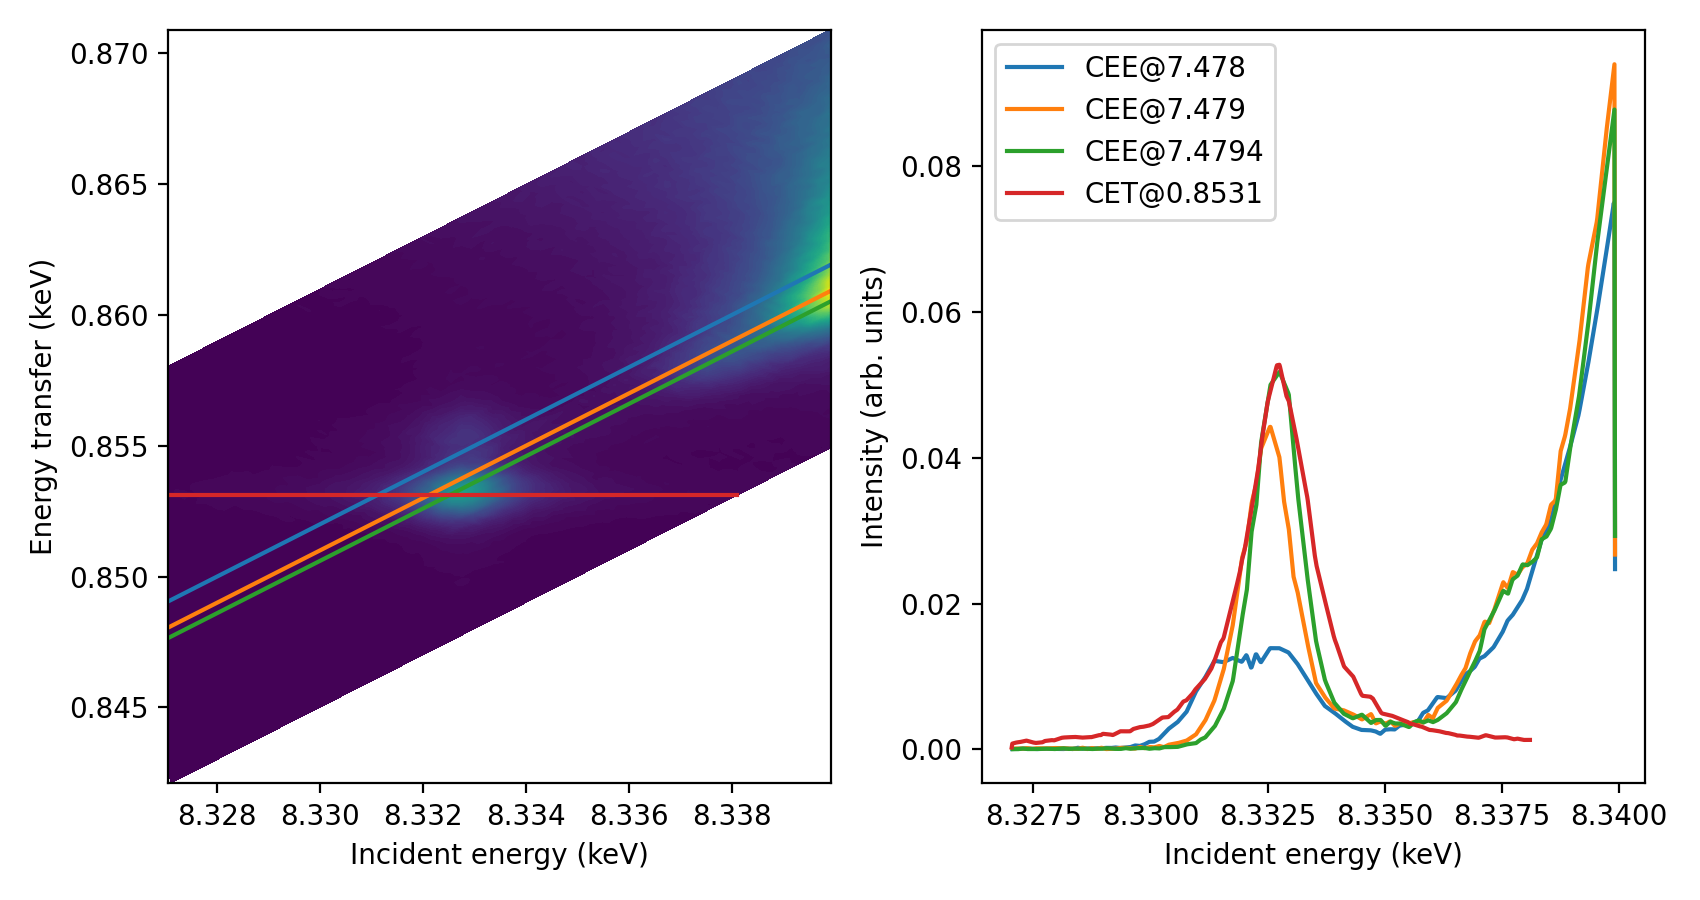

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.5, 4.5))

ax1.tricontourf(measurement.x, measurement.y, measurement.signal, levels=levels)

for label, (x, y, signal) in measurement.cuts.items():
    if "CIE" in label:
        continue
        
    ax1.plot(x, y)

    ids = np.argsort(x)
    x = x[ids]
    y = y[ids]
    signal = signal[ids]

    ax2.plot(x, signal, label=label)

ax1.set_xlabel("Incident energy (keV)")
ax1.set_ylabel("Energy transfer (keV)")

ax2.set_xlabel("Incident energy (keV)")
ax2.set_ylabel("Intensity (arb. units)")

ax2.legend() 
plt.tight_layout()

## Interpolate the plane

<IPython.core.display.Javascript object>


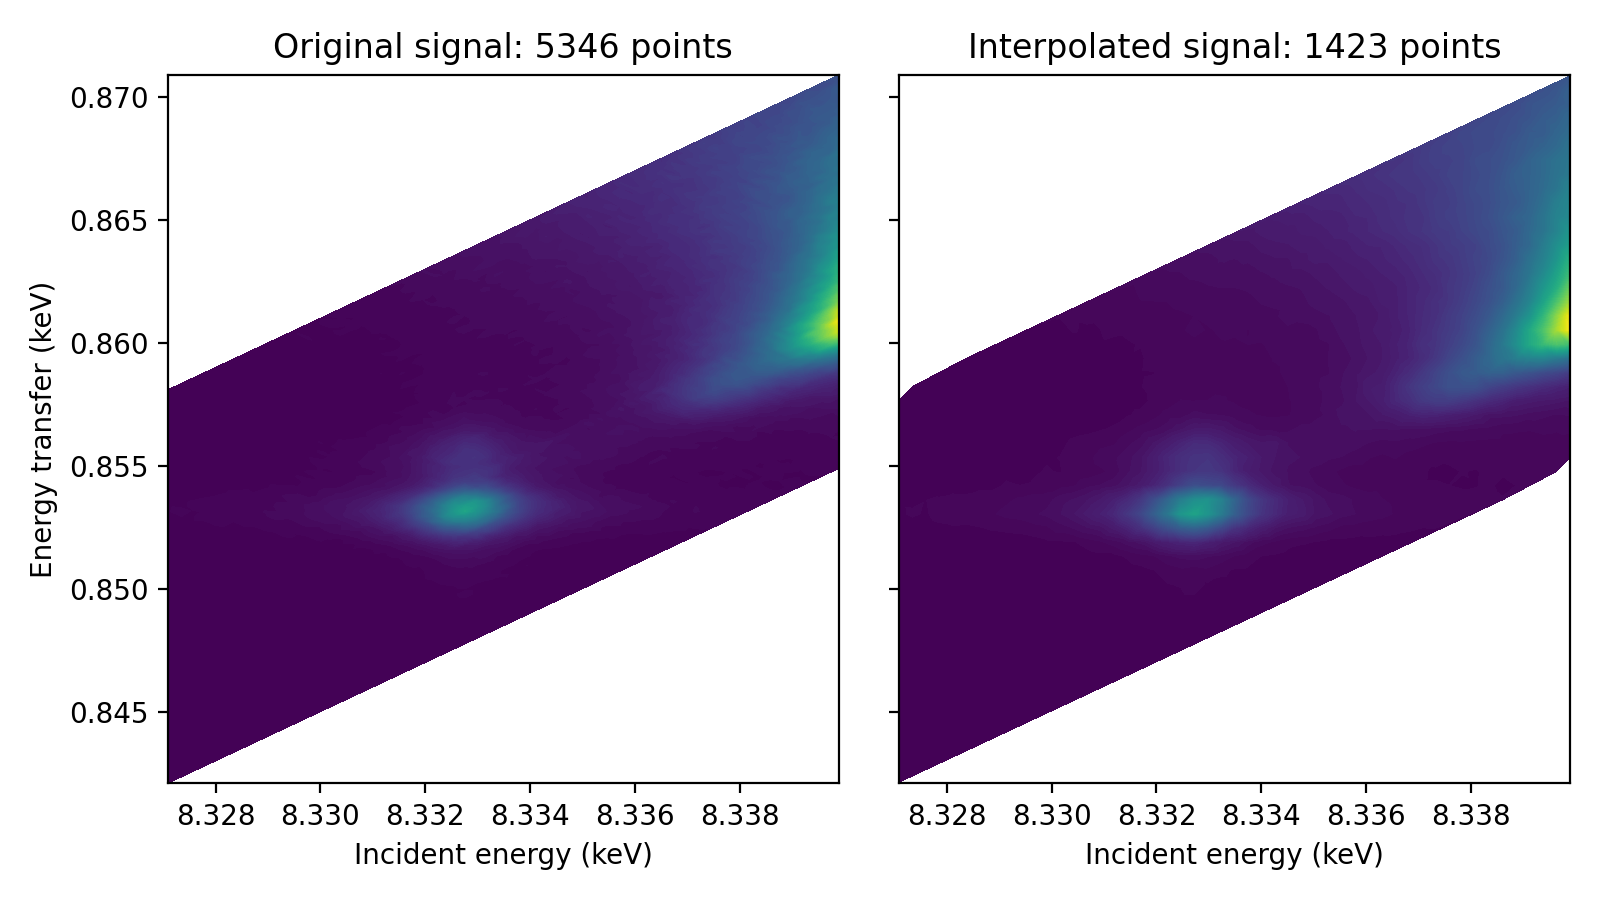

INFO:daxs.interpolators:The interpolator parameters have been updated.


In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)

measurement.reset()

# Plot the plane original plane.
ax1.tricontourf(measurement.x, measurement.y, measurement.signal, levels=levels)
ax1.set_xlabel("Incident energy (keV)")
ax1.set_ylabel("Energy transfer (keV)")
ax1.set_title(f"Original signal: {len(measurement.signal)} points")

npoints = 51
shift = 5e-5
x, y, signal = measurement.x, measurement.y, measurement.signal
xi = np.linspace(x.min() + shift, x.max() - shift, npoints)
yi = np.linspace(y.min() + shift, y.max() - shift, npoints)
measurement.interpolate(xi, yi)

# Plot the plane the interpolated plane.
ax2.tricontourf(measurement.x, measurement.y, measurement.signal, levels=levels)
ax2.set_xlabel("Incident energy (keV)")
ax2.set_title(f"Interpolated signal: {len(measurement.signal)} points")

plt.tight_layout()